Load Librairies

In [1]:
import pandas as pd                 # Data
import numpy as np                  # Data
import matplotlib.pyplot as plt     # Plot
from scipy.stats import rankdata    # Return period

Use Latex Font

In [2]:
plt.rcParams.update({
    "text.usetex": True,                # Use LaTeX for text
    "font.family": "serif",             # Use 'serif' font
    "font.serif": ["Computer Modern"],  # LaTeX default font
    "font.size": 11,                    # General font size
    "axes.labelsize": 11,               # Font size for labels
    "legend.fontsize": 11,              # Font size for legend
    "xtick.labelsize": 10,              # Font size for x-axis
    "ytick.labelsize": 10               # Font size for y-axis
})

# Data

In [3]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

In [4]:
def calculate_return_period(droughts:pd.DataFrame):
    droughts_sorted = droughts.sort_values('Duration')
    droughts_sorted['rank'] = rankdata(droughts_sorted['Duration'])
    droughts_sorted['exceedance_probability'] = (len(droughts_sorted)-droughts_sorted['rank']+1)/(len(droughts_sorted)+1)
    droughts_sorted['return_period'] = 1./droughts_sorted['exceedance_probability']
    droughts_sorted['return_years'] = droughts_sorted['return_period']*44/len(droughts_sorted)
    return droughts_sorted

In [5]:
df_combine = pd.read_csv('../Data/cf_combine_7923.csv',
                         index_col=0,
                         parse_dates=True
)

df_combine_avg = df_combine.rolling('D', min_periods=24, center=True).mean()

In [6]:
droughts_dict = {}

for column in df_combine_avg:
    raw_droughts = identify_drought(df_combine_avg[column], 0.1)
    droughts = raw_droughts[raw_droughts > 24]
    droughts_df = pd.DataFrame(droughts)
    droughts_df = droughts_df.set_axis(['Duration'], axis=1)
    droughts_dict[column] = droughts_df

In [7]:
return_dict = {}
for key, value in droughts_dict.items():
    return_dict[key] = calculate_return_period(value)

# Plot

In [8]:
def my_title(ax, title, fs = 12):
    ax.set_title(title, 
                 x=0.5, y=1,
                 pad = -14,
                 fontsize=fs, 
                 bbox=dict(facecolor='white', alpha=1, edgecolor='white'))

In [9]:
def plot_lines(axs):
    axs[2].plot((0.03, 45), (5,5), '--k', alpha=0.6)
    axs[3].plot((0.03, 45), (5,5), '--k', alpha=0.6)

    axs[2].plot((0.57, 0.57), (0,5), '--', color = color_models[0])
    axs[3].plot((4, 4), (0,5), '--', color = color_models[0])

    axs[2].plot((1.4, 1.4), (0,5), '--', color = color_models[1])
    axs[3].plot((5.5, 5.5), (0,5), '--', color = color_models[1])

    axs[2].plot((1.15, 1.15), (0,5), '--', color = color_models[2])
    axs[3].plot((4.9, 4.9), (0,5), '--', color = color_models[2])

In [10]:
label_name = ['Atlite', 'C3S-E G', 'C3S-E N']
title_name = ['a) Wind', 'b) PV', 'c) Existing', 'd) Balanced']
color_models = ['#B03024', '#348ABD', '#988ED5']
sign_models = ['^', 'o', 's']

In [11]:
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']

In [12]:
categories = {
    'onshorewind': ['onshorewind_atlite', 'onshorewind_c3se_gridded', 'onshorewind_c3se_national'],
    'pv': ['pv_atlite', 'pv_c3se_gridded', 'pv_c3se_national'],
    'combine_2023': ['combine_atlite_2023', 'combine_c3se_gridded_2023', 'combine_c3se_national_2023'],
    'combine_2030': ['combine_atlite_2030', 'combine_c3se_gridded_2030', 'combine_c3se_national_2030']
}

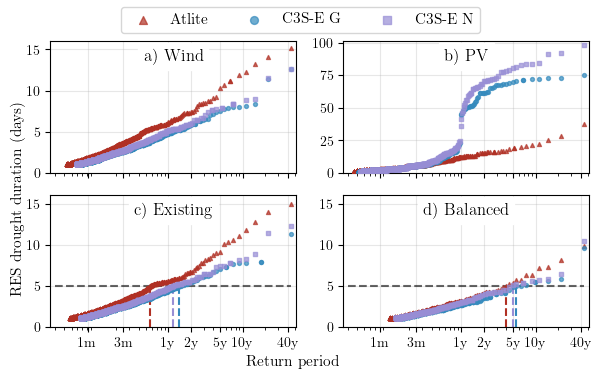

In [13]:
# Create subplots
cm = 1/2.54
fig, axs = plt.subplots(2, 2, 
                        figsize=(16*cm, 10*cm), 
                        sharex=True)
axs = axs.flatten()

for idx, (category, datasets_in_category) in enumerate(categories.items()):
    ax = axs[idx]

    for i, name in enumerate(datasets_in_category):

        ax.scatter(return_dict[name]['return_years'], return_dict[name]['Duration'] / 24, 
                   s = 8,
                   marker = sign_models[i],
                   color = color_models[i],
                   alpha = 0.7,
                   zorder = 3
        )
    # Panel Settings
    my_title(ax, title_name[idx])
    ax.grid(True, alpha=0.3, zorder=0)
    ax.margins(0.02)
    # x-axis
    ax.set_xscale('log')
    ax.set_xticks([7/365, 30/365, 91/365, 1, 2, 5, 10, 40])
    ax.set_xticklabels(['1w', '1m', '3m', '1y', '2y', '5y', '10y', '40y'])
    # y-axis
    if idx != 1:
        ax.set_ylim(0,16)
    else:
        ax.set_ylim(0,101)
        ax.set_yticks(range(0, 101, 25))


plot_lines(axs)
# Legend
fig.legend(labels = label_name,
           loc = 'upper center',
           ncol = 3,
           markerscale = 2,
           fontsize = 11)

fig.supxlabel('Return period', y = 0.07, fontsize = 11)
fig.supylabel('RES drought duration (days)', x = 0.05, fontsize = 11)
fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.savefig('droughts_return_periods.pdf', bbox_inches='tight')